In [1]:
#https://drive.google.com/open?id=1NVfn_L9YoGJloB_rzKh06YCqQNe6DfJj
%cd /content
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html
'''
# 2. Create & upload a file text file.
uploaded = drive.CreateFile({'title': 'combined_csv_1.csv'})
uploaded.SetContentFile('combined_csv_1.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))
'''

/content


"\n# 2. Create & upload a file text file.\nuploaded = drive.CreateFile({'title': 'combined_csv_1.csv'})\nuploaded.SetContentFile('combined_csv_1.csv')\nuploaded.Upload()\nprint('Uploaded file with ID {}'.format(uploaded.get('id')))\n"

In [0]:
# https://drive.google.com/open?id=1lc0hEBQ8-4eHcpmxaUD0eHQAwTiFfJUY
downloaded = drive.CreateFile({'id': '1lc0hEBQ8-4eHcpmxaUD0eHQAwTiFfJUY'})
downloaded.GetContentFile('small_answers_train.h5')

# https://drive.google.com/open?id=1PbkIacc1xu9GbQJ68kL3Z5p3UQml4ptP
downloaded = drive.CreateFile({'id': '1PbkIacc1xu9GbQJ68kL3Z5p3UQml4ptP'})
downloaded.GetContentFile('small_answers_val.h5')

# https://drive.google.com/open?id=1TNSzN1k2YMZzgjwYyrKm2VMxfAWC-DaG
downloaded = drive.CreateFile({'id': '1TNSzN1k2YMZzgjwYyrKm2VMxfAWC-DaG'})
downloaded.GetContentFile('small_img_features_train.h5')

# https://drive.google.com/open?id=18nAha86shtCyD8TTDMTgqWeL17Qd5D4y
downloaded = drive.CreateFile({'id': '18nAha86shtCyD8TTDMTgqWeL17Qd5D4y'})
downloaded.GetContentFile('small_img_features_val.h5')

# https://drive.google.com/open?id=1PMOMRubTwItMuCJX5Xw-qco_3EsyZRTt
downloaded = drive.CreateFile({'id': '1PMOMRubTwItMuCJX5Xw-qco_3EsyZRTt'})
downloaded.GetContentFile('small_question_train_tokenize.h5')

# https://drive.google.com/open?id=1IgMZE9rkGtmYrJDUhScWvtb4vjW0WrJ_
downloaded = drive.CreateFile({'id': '1IgMZE9rkGtmYrJDUhScWvtb4vjW0WrJ_'})
downloaded.GetContentFile('small_question_val_tokenize.h5')

# https://drive.google.com/open?id=1zQvl9cYhqk2bRsXWMrnNUn_tvab3XRQS
downloaded = drive.CreateFile({'id': '1zQvl9cYhqk2bRsXWMrnNUn_tvab3XRQS'})
downloaded.GetContentFile('embedding_matrix_tokenize.h5')


In [0]:
# For small vqa training
import h5py

h5_img = h5py.File('small_img_features_train.h5', 'r')
img_features_train = h5_img['small_img_features_train'][:]

h5_img = h5py.File('small_img_features_val.h5', 'r')
img_features_val = h5_img['small_img_features_val'][:]

h5_ans = h5py.File('small_answers_train.h5', 'r')
answer_train = h5_ans['small_answers_train'][:]
h5_ans.close()

h5_ans = h5py.File('small_answers_val.h5', 'r')
answer_val   = h5_ans['small_answers_val'][:]
h5_ans.close()

h5_que = h5py.File('small_question_train_tokenize.h5', 'r')
question_train = h5_que['small_question_train_tokenize'][:]

h5_que = h5py.File('small_question_val_tokenize.h5', 'r')
question_val = h5_que['small_question_val_tokenize'][:]

In [0]:
import numpy as np

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

img_features_train = np.repeat(img_features_train, 3, 0)
img_features_val = np.repeat(img_features_val, 3, 0)

In [0]:
import tensorflow as tf
import os, pandas as pd, numpy as np
import tensorflow.keras.backend as k
import h5py, pickle
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, CuDNNLSTM, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
k.clear_session()

NAME = "1_model_one_lstm_vgg"

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

#x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = CuDNNLSTM(units=512, return_sequences=False)(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
#lstm_2 = CuDNNLSTM(units=512, return_sequences=False)(dropout__ques_1)
#dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
#reshape = reshape((4096,))(image_input)
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_1 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model_1.summary() 

history = model_1.fit([img_features_train,question_train ],answer_train, epochs = 50, shuffle = True, 
            validation_data = [[img_features_val, question_val], answer_val])

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["1_model_one_lstm_vgg" for i in range(50)]
model_metric_1 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])
model_metric_1.to_csv("model_metric_1.csv")

model_1.save('1_model_one_lstm_vgg.h5')

uploaded = drive.CreateFile({'title': '1_model_one_lstm_vgg.h5'})
uploaded.SetContentFile('1_model_one_lstm_vgg.h5')
uploaded.Upload()

W0624 16:10:25.147557 139814710015872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating text model...


W0624 16:10:26.999912 139814710015872 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm (CuDNNLSTM)          (None, 512)          1667072     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
_______________________________________________

'val_loss = history.history[\'val_loss\']\nval_acc = history.history[\'val_acc\']\nloss = history.history[\'loss\']\nacc = history.history[\'acc\']\nmodels = ["1_model_one_lstm_vgg" for i in range(50)]\nmodel_metric_1 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), \n                               columns=[\'models\', \'accuracy\', \'loss\', \'validation_accuracy\', \'validation_loss\'])\nmodel_metric_1.to_csv("model_metric_1.csv")\n\nmodel_1.save(\'1_model_one_lstm_vgg.h5\')\n\nuploaded = drive.CreateFile({\'title\': \'1_model_one_lstm_vgg.h5\'})\nuploaded.SetContentFile(\'1_model_one_lstm_vgg.h5\')\nuploaded.Upload()'

In [0]:
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = CuDNNGRU(units=512, return_sequences=False)(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
.dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_2 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_2.summary()

history = model_2.fit([img_features_train,question_train ],answer_train, epochs = 50, shuffle = True, 
            validation_data = [[img_features_val,question_val],answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["2_model_one_gru_vgg" for i in range(50)]
model_metric_2 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_2.to_csv("model_metric_2.csv")

model_2.save('2_model_one_gru_vgg.h5')

uploaded = drive.CreateFile({'title': '2_model_one_GRU_vgg.h5'})
uploaded.SetContentFile('2_model_one_gru_vgg.h5')
uploaded.Upload()


Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnngru (CuDNNGRU)            (None, 512)          1250304     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

In [0]:
# Bidirectional LSTM
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNLSTM, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))
#question_input = Input(tensor=question)

#x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNLSTM(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
#lstm_2 = CuDNNLSTM(units=512, return_sequences=False)(dropout__ques_1)
#dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
#reshape = reshape((4096,))(image_input)
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_3 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_3.summary()

history = model_3.fit([img_features_train,question_train ],answer_train, epochs = 50, shuffle = True, 
            validation_data = [[img_features_val,question_val ],answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["3_model_one_bid_lstm_vgg" for i in range(50)]
model_metric_3 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_3.to_csv("model_metric_3.csv")
model_3.save('3_model_one_bid_LSTM_vgg.h5')

uploaded = drive.CreateFile({'title': '3_model_one_bid_LSTM_vgg.h5'})
uploaded.SetContentFile('3_model_one_bid_LSTM_vgg.h5')
uploaded.Upload()

W0623 18:54:13.004258 140288750835584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 18:54:13.005866 140288750835584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0623 18:54:13.009292 140288750835584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is de

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         3334144     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

In [10]:
# Bidirectional GRU
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))
#question_input = Input(tensor=question)

#x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNGRU(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
#lstm_2 = CuDNNLSTM(units=512, return_sequences=False)(dropout__ques_1)
#dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)
print ("Creating image model...")

image_input = Input(shape=(4096, ) )
#reshape = reshape((4096,))(image_input)
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_4 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_4.summary()

history = model_4.fit([img_features_train,question_train ],answer_train, epochs = 50, shuffle = True, validation_data = [[img_features_val, question_val], answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["4_model_one_bid_gru_vgg" for i in range(50)]
model_metric_4 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_4.to_csv("model_metric_4.csv")

model_4.save('4_model_one_bid_GRU_vgg.h5')

uploaded = drive.CreateFile({'title': '4_model_one_bid_GRU_vgg.h5'})
uploaded.SetContentFile('4_model_one_bid_GRU_vgg.h5')
uploaded.Upload()

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         2500608     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
________________________

In [0]:
# Bags of word implementation
# Bags of word implementation
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)
import pandas as pd
import numpy as np
import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout,  Flatten, Embedding, Conv1D, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

combine_feature_train = np.hstack((img_features_train , question_train))
combine_feature_val = np.hstack((img_features_val, question_val ))

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5

word_dim = 25
img_dim = 4096
input_feats = Input(shape=(word_dim + img_dim, ))

#x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], 
#              input_length = img_dim + word_dim, trainable = False)(input_feats)

dense_1 = Dense(1024, activation='relu')(input_feats)
dropout_1 = Dropout(dropout_rate)(dense_1)
dense_2 = Dense(1024,  activation='relu')(dropout_1)
dropout_2 = Dropout(dropout_rate)(dense_2)

dense_3 = Dense(1024,  activation='relu')(dropout_2)
dropout_3 = Dropout(dropout_rate)(dense_3)

dense_4 = Dense(1001, activation = "softmax")(dropout_3)

model_5 = Model(inputs = input_feats, outputs = dense_4)
opt = SGD(lr = 0.01)
model_5.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_5.summary()

history = model_5.fit(combine_feature_train, answer_train, epochs = 50, shuffle = True, validation_data = [combine_feature_val, answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["5_model_bow_mlp_vgg" for i in range(50)]
model_metric_5 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_5.to_csv("model_metric_5.csv")

model_5.save('5_model_bow_mlp_vgg.h5')

uploaded = drive.CreateFile({'title': '5_model_bow_mlp_vgg.h5'})
uploaded.SetContentFile('5_model_bow_mlp_vgg.h5')
uploaded.Upload()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4121)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4220928   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0     

In [9]:
# CNN proposed architecture on textual data.
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding, MaxPooling1D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5

print ("Creating text model...")

question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)

l_cov1= Conv1D(128, 1, activation='relu')(x)
l_pool1 = MaxPooling1D(1)(l_cov1)

l_cov2 = Conv1D(128, 1, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(1)(l_cov2)

l_cov3 = Conv1D(128, 1, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(1)(l_cov3)  # global max pooling

l_flat = Flatten()(l_pool3)

l_dense = Dense(128, activation='relu')(l_flat)

dense_ques_1 = Dense(1024, activation='tanh')(l_dense)

print ("Creating image model...")
image_input = Input(shape=(4096, ) )
dense_img_1 = Dense(1024,  activation='relu')(image_input)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_1, dense_ques_1])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_6 = Model(inputs=[image_input, question_input], outputs=dense_2)
opt = SGD(lr = 0.01)
model_6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_6.summary()

history = model_6.fit([img_features_train,question_train ],answer_train, epochs = 50, shuffle = True, validation_data = [[img_features_val, question_val], answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["6_model_cnn_vgg" for i in range(50)]
model_metric_6 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_6.to_csv("model_metric_6.csv")

model_6.save('6_model_cnn_vgg.h5')

uploaded = drive.CreateFile({'title': '6_model_cnn_vgg.h5'})
uploaded.SetContentFile('6_model_cnn_vgg.h5')
uploaded.Upload()

Creating text model...
Creating image model...
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 25, 128)      38528       embedding[0][0]                  
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 25, 128)      0           conv1d[0][0]                     
________________________

In [8]:
# 2 vis lstm.
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py, pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNLSTM, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5

print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)

lstm_1 = CuDNNLSTM(units=512, return_sequences=False)(x)
dropout_ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout_ques_1)

print ("Creating image model...")
image_input_model_1 = Input(shape=(4096, ) )
dense_img_model_1 = Dense(1024,  activation='relu')(image_input_model_1)

print("creating image model 2")
image_input_model_2 = Input(shape=(4096, ) )
dense_img_model_2 = Dense(1024,  activation='relu')(image_input_model_2)

print ("Merging final model...")

concatenate_1 = concatenate([dense_img_model_1, dense_ques_1, dense_img_model_2])

dropout_1 = Dropout(0.5)(concatenate_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_7 = Model(inputs=[image_input_model_1, question_input, image_input_model_2], outputs=dense_2)
opt = SGD(lr = 0.01)
model_7.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_7.summary()

history = model_7.fit([img_features_train, question_train, img_features_train], answer_train, epochs = 50, shuffle = True, 
			validation_data = [[img_features_val, question_val, img_features_val], answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["7_model_2_vis_lstm_vgg" for i in range(50)]
model_metric_7 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_7.to_csv("model_metric_7.csv")

model_7.save('7_model_2_vis_lstm_vgg.h5')

uploaded = drive.CreateFile({'title': '7_model_2_vis_lstm_vgg.h5'})
uploaded.SetContentFile('7_model_2_vis_lstm_vgg.h5')
uploaded.Upload()

Creating text model...
Creating image model...
creating image model 2
Merging final model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      4833000     input_1[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm (CuDNNLSTM)          (None, 512)          1667072     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
_

In [7]:
# language only model

import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNLSTM, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5
print ("Creating text model...")
question_input = Input(shape=(25, ))

x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
lstm_1 = Bidirectional(CuDNNLSTM(units=512, return_sequences=False))(x)
dropout__ques_1 = Dropout(dropout_rate)(lstm_1)

dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_1)

dropout_1 = Dropout(0.5)(dense_ques_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_8 = Model(inputs=question_input, outputs=dense_2)
opt = SGD(lr = 0.01)
model_8.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_8.summary()

history = model_8.fit(question_train, answer_train, epochs = 50, shuffle = True, 
            validation_data = [question_val,answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']

models = ["8_model_lang_only_one_bid_lstm" for i in range(50)]
model_metric_8 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_8.to_csv("model_metric_8.csv")
model_8.save('8_model_one_bid_LSTM_vgg.h5')

uploaded = drive.CreateFile({'title': '8_model_lang_only_one_bid_LSTM.h5'})
uploaded.SetContentFile('8_model_lang_only_one_bid_LSTM.h5')
uploaded.Upload()

W0704 18:47:10.445788 139700661716864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0704 18:47:10.557178 139700661716864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0704 18:47:10.558544 139700661716864 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) w

Creating text model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 25, 300)           4833000   
_________________________________________________________________
bidirectional (Bidirectional (None, 1024)              3334144   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10

In [6]:
# image model only
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
import pandas as pd
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta
import tensorflow.keras.backend as k
k.clear_session()

val_loss = []
val_acc = []
loss = []
acc = []

dropout_rate = 0.5

print ("Creating image model...")

image_input = Input(shape=(4096, ) )
dense_img_1 = Dense(1024,  activation='relu')(image_input)

dropout_1 = Dropout(0.5)(dense_img_1)
dense_1 = Dense(1001, activation = "tanh")(dropout_1)
dropout_2 = Dropout(0.5)(dense_1)    
dense_2 = Dense(1001, activation = "softmax")(dropout_2)

model_9 = Model(inputs= image_input, outputs=dense_2)
opt = SGD(lr = 0.01)
model_9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model_9.summary()

history = model_9.fit(img_features_train, answer_train, epochs = 50, shuffle = True, validation_data = [img_features_val, answer_val] )

val_loss = history.history['val_loss']
val_acc = history.history['val_acc']
loss = history.history['loss']
acc = history.history['acc']
models = ["9_model_image_only" for i in range(50)]
model_metric_9 = pd.DataFrame(np.column_stack([models, acc, loss, val_acc, val_loss]), 
                               columns=['models', 'accuracy', 'loss', 'validation_accuracy', 'validation_loss'])

model_metric_9.to_csv("model_metric_9.csv")

model_9.save('9_model_image_only.h5')

uploaded = drive.CreateFile({'title': '9_model_image_only.h5'})
uploaded.SetContentFile('9_model_image_only.h5')
uploaded.Upload()

Creating image model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4096)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4195328   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1001)              1026025   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1001)              1003002   
Total params: 6,224,355
Trainable params: 6,224,355
Non-trainable params: 0
___________________________

Let's plot their metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

metric_files = ["model_metric_1.csv", "model_metric_2.csv", "model_metric_3.csv", "model_metric_4.csv", "model_metric_5.csv", "model_metric_6.csv", "model_metric_7.csv", "model_metric_8.csv", "model_metric_9.csv"]

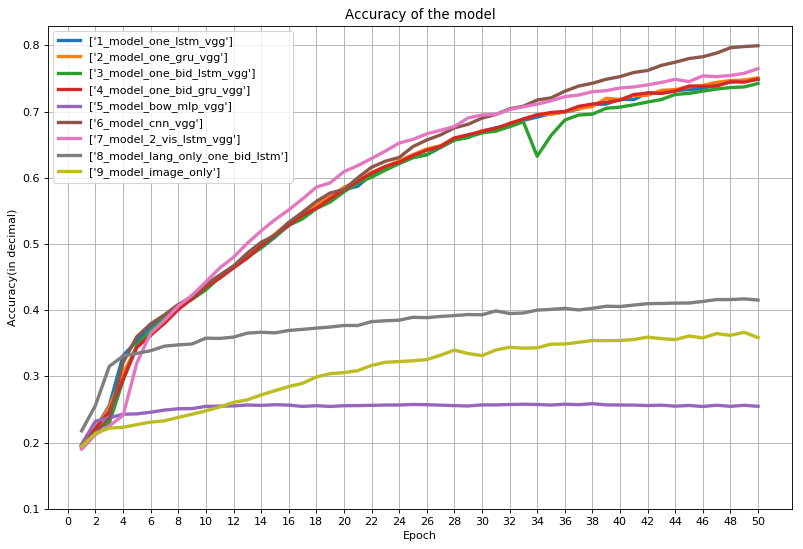

In [19]:
figure(num=None, figsize=(12, 8), dpi=80)
accuracy = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Accuracy of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy(in decimal)")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["accuracy"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 3)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.1, 0.9, 0.1))
plt.gca().legend(name)
plt.show()

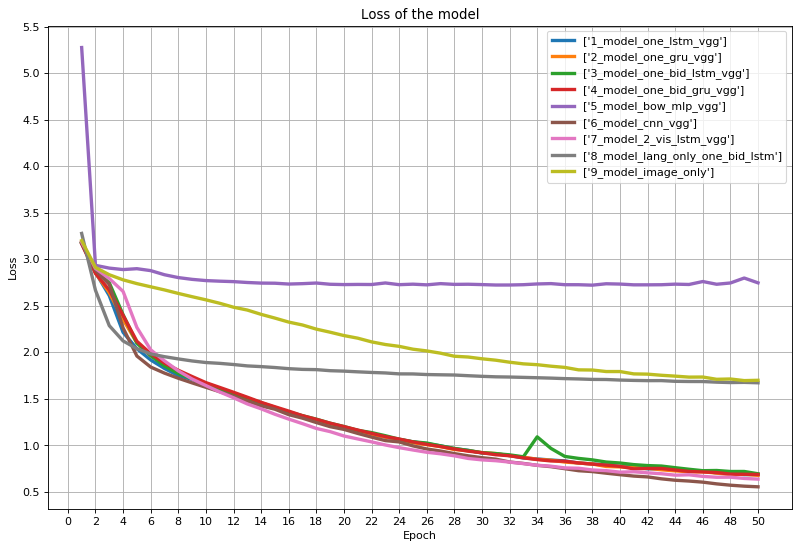

In [18]:
figure(num=None, figsize=(12, 8), dpi=80)
loss = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Loss of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["loss"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 3)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.5, 6, 0.5))
plt.gca().legend(name)
plt.show()

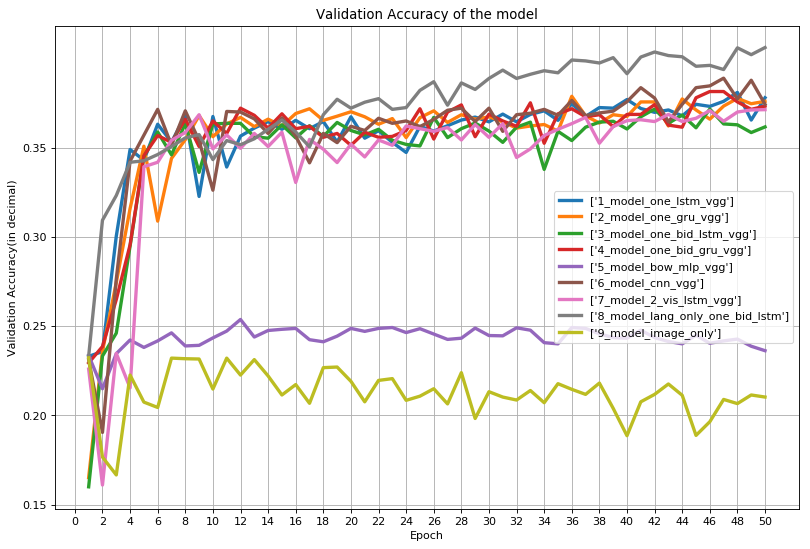

In [17]:
figure(num=None, figsize=(12, 8), dpi=80)
validation_accuracy = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Validation Accuracy of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Validation Accuracy(in decimal)")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["validation_accuracy"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 3)
    plt.xticks(np.arange(0, 51, 2))
    plt.yticks(np.arange(0.15, 0.4, 0.05))
plt.gca().legend(name)
plt.show()

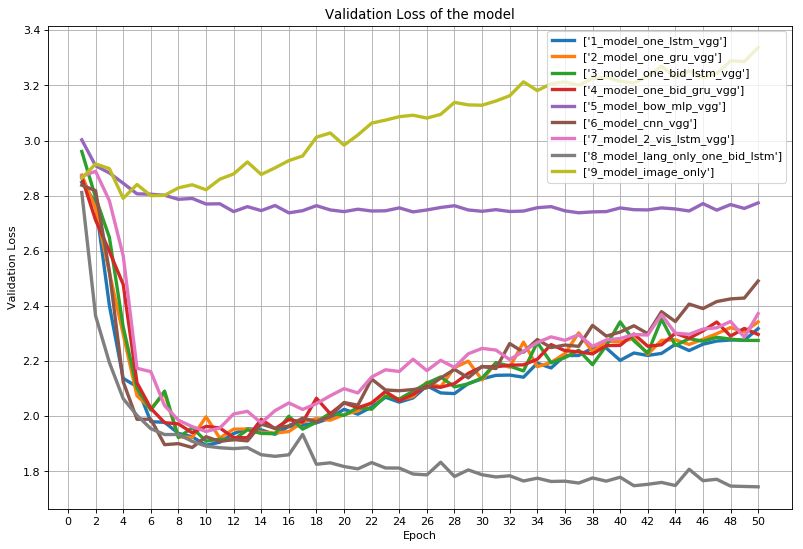

In [16]:
figure(num=None, figsize=(12, 8), dpi=80)
validation_loss = []
name = []
axes= plt.axes()
axes.grid()
axes.set_title('Validation Loss of the model')
axes.set_xlabel("Epoch")
axes.set_ylabel("Validation Loss")
for i in metric_files:
    metric = pd.read_csv(i)
    accuracy = metric["validation_loss"]
    name.append(list(set(metric["models"])) )
    epochs = np.arange(1, 51, 1)
    line1, = plt.plot(epochs, accuracy, linewidth = 3)
    plt.xticks(np.arange(0, 51, 2))
    #plt.yticks(np.arange(0.15, 0.45, 0.05))
plt.gca().legend(name)
plt.show()

In [0]:
# Model with lstm 2 and more...
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, CuDNNLSTM, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta

img_features_train = np.repeat(img_features_train, 3, 0)
img_features_val = np.repeat(img_features_val, 3, 0)

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

dropout_rate = 0.5
convolutional_layers = [2, 3]

for conv_layer in convolutional_layers:

  name = "model_bid_LSTM_{}_vgg_embed_tok.h5".format(conv_layer)

  print ("Creating text model...")
  question_input = Input(shape=(25, ))
  #question_input = Input(tensor=question)

  #x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
  lstm_1 = CuDNNLSTM(units=512, return_sequences=True)(x)
  dropout__ques_1 = Dropout(dropout_rate)(lstm_1)
  
  
  for i in range(conv_layer-1):
    if i == 0:
      if conv_layer == 2:
        sequence = False
      elif conv_layer == 3:
        sequence = True
      input_layer = dropout__ques_1
    elif i == 1:
      sequence = False
      input_layer = dropout__ques_2
    lstm_2 = CuDNNLSTM(units=512, return_sequences=sequence)(input_layer)
    dropout__ques_2 = Dropout(dropout_rate)(lstm_2)

  dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_2)
  print ("Creating image model...")

  image_input = Input(shape=(4096, ) )
  #reshape = reshape((4096,))(image_input)
  dense_img_1 = Dense(1024,  activation='relu')(image_input)

  print ("Merging final model...")

  concatenate_1 = concatenate([dense_img_1, dense_ques_1])

  dropout_1 = Dropout(0.5)(concatenate_1)
  dense_1 = Dense(1001, activation = "tanh")(dropout_1)
  dropout_2 = Dropout(0.5)(dense_1)    
  dense_2 = Dense(1001, activation = "softmax")(dropout_2)

  model_5 = Model(inputs=[image_input, question_input], outputs=dense_2)
  opt = SGD(lr = 0.01)
  model_5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model_5.summary()

  model_5.fit([img_features_train,question_train ],answer_train, epochs = 100, shuffle = True )
  
  model_5.save(name)

  loss, accuracy = model_5.evaluate([img_features_val, question_val ],answer_val)

  print(loss, accuracy)


Creating text model...
Creating image model...
Merging final model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 25, 300)      64523100    input_8[0][0]                    
__________________________________________________________________________________________________
cu_dnnlstm_10 (CuDNNLSTM)       (None, 25, 512)      1667072     embedding_4[0][0]                
__________________________________________________________________________________________________
dropout_15 (Dropout)            (None, 25, 512)      0           cu_dnnlstm_10[0][0]              
_______________________________________

In [0]:
# Model with lstm 2 and more...
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta

img_features_train = np.repeat(img_features_train, 3, 0)
img_features_val = np.repeat(img_features_val, 3, 0)

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

dropout_rate = 0.5
GRU_layers = [1, 2, 3]

for gru_layer in GRU_layers:

  name = "model_GRU_{}_vgg_embed_tok".format(gru_layer)

  print ("Creating text model...")
  question_input = Input(shape=(25, ))
  #question_input = Input(tensor=question)

  #x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
  if(gru_layer == 1) :
    sequence = False
  else:
    sequence = True
  gru_1 = CuDNNGRU(units=512, return_sequences=sequence)(x)
  dropout__ques_1 = Dropout(dropout_rate)(gru_1)
  
  if(gru_layer == 1):
    dropout__ques_2 = dropout__ques_1
  
  for i in range(gru_layer-1):
    if i == 0:
      if gru_layer == 2:
        sequence = False
      elif gru_layer == 3:
        sequence = True
      input_layer = dropout__ques_1
    elif i == 1:
      sequence = False
      input_layer = dropout__ques_2
    gru_2 = CuDNNGRU(units=512, return_sequences=sequence)(input_layer)
    dropout__ques_2 = Dropout(dropout_rate)(gru_2)

  dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_2)
  print ("Creating image model...")

  image_input = Input(shape=(4096, ) )
  #reshape = reshape((4096,))(image_input)
  dense_img_1 = Dense(1024,  activation='relu')(image_input)

  print ("Merging final model...")

  concatenate_1 = concatenate([dense_img_1, dense_ques_1])

  dropout_1 = Dropout(0.5)(concatenate_1)
  dense_1 = Dense(1001, activation = "tanh")(dropout_1)
  dropout_2 = Dropout(0.5)(dense_1)    
  dense_2 = Dense(1001, activation = "softmax")(dropout_2)

  model_5 = Model(inputs=[image_input, question_input], outputs=dense_2)
  opt = SGD(lr = 0.01)
  model_5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model_5.summary()

  model_5.fit([img_features_train,question_train ],answer_train, epochs = 100, shuffle = True )
  
  model_5.save(name)

  loss, accuracy = model_5.evaluate([img_features_val, question_val ],answer_val)

  print(loss, accuracy)
  
  # upload to google drive
  uploaded = drive.CreateFile({'title': '{}.h5'.format(name)})
  uploaded.SetContentFile('{}.h5'.format(name))
  uploaded.Upload()


Creating text model...
Creating image model...
Merging final model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      64523100    input_3[0][0]                    
__________________________________________________________________________________________________
cu_dnngru_1 (CuDNNGRU)          (None, 512)          1250304     embedding_1[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 4096)         0                                            
_______________________________________

FileNotFoundError: ignored

In [0]:
# Model with lstm 2 and more...
import tensorflow as tf
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.3)
config = tf.ConfigProto(gpu_options = gpu_options)
config.gpu_options.allow_growth=True
session = tf.Session( config = config)

import h5py
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Bidirectional, CuDNNGRU, Flatten, Embedding, concatenate, Conv1D, Input, Embedding
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD, Adadelta

img_features_train = np.repeat(img_features_train, 3, 0)
img_features_val = np.repeat(img_features_val, 3, 0)

h5_que = h5py.File('embedding_matrix_tokenize.h5', 'r')
embedding_matrix = h5_que['embedding_matrix_tokenize'][:]

dropout_rate = 0.5
GRU_layers = [3]

for gru_layer in GRU_layers:

  name = "model_bidirectional_GRU_{}_vgg_embed_tok.h5".format(gru_layer)

  print ("Creating text model...")
  question_input = Input(shape=(25, ))
  #question_input = Input(tensor=question)

  #x = Embedding(output_dim=512, input_dim=125, input_length=25)(question_input)
  x = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights = [embedding_matrix], input_length=25, trainable = False)(question_input)
  if(gru_layer == 1) :
    sequence = False
  else:
    sequence = True
  gru_1 = Bidirectional(CuDNNGRU(units=512, return_sequences=sequence))(x)
  dropout__ques_1 = Dropout(dropout_rate)(gru_1)
  
  if(gru_layer == 1):
    dropout__ques_2 = dropout__ques_1
  
  for i in range(gru_layer-1):
    if i == 0:
      if gru_layer == 2:
        sequence = False
      elif gru_layer == 3:
        sequence = True
      input_layer = dropout__ques_1
    elif i == 1:
      sequence = False
      input_layer = dropout__ques_2
    gru_2 = Bidirectional(CuDNNGRU(units=512, return_sequences=sequence))(input_layer)
    dropout__ques_2 = Dropout(dropout_rate)(gru_2)

  dense_ques_1 = Dense(1024, activation='tanh')(dropout__ques_2)
  print ("Creating image model...")

  image_input = Input(shape=(4096, ) )
  #reshape = reshape((4096,))(image_input)
  dense_img_1 = Dense(1024,  activation='relu')(image_input)

  print ("Merging final model...")

  concatenate_1 = concatenate([dense_img_1, dense_ques_1])

  dropout_1 = Dropout(0.5)(concatenate_1)
  dense_1 = Dense(1001, activation = "tanh")(dropout_1)
  dropout_2 = Dropout(0.5)(dense_1)    
  dense_2 = Dense(1001, activation = "softmax")(dropout_2)

  model_5 = Model(inputs=[image_input, question_input], outputs=dense_2)
  opt = SGD(lr = 0.01)
  model_5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  model_5.summary()

  model_5.fit([img_features_train,question_train ],answer_train, epochs = 100, shuffle = True )
  
  model_5.save(name)

  loss, accuracy = model_5.evaluate([img_features_val, question_val ],answer_val)

  print(loss, accuracy)
  
  # upload to google drive
  #uploaded = drive.CreateFile({'title': '{}'.format(name)})
  #uploaded.SetContentFile('{}'.format(name))
  #uploaded.Upload()


Creating text model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Creating image model...
Merging final model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 25, 300)      64523100    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 25, 1024)     2500608     embedding[0][0]                  
__________________________________________________

Continue to the next Notebook